In [2]:
import sys
sys.path.append("../")

from __init__ import *
from data_tools import *
from testing import *

import keras
import tensorflow

In [3]:
frame = pd.read_csv("../data/simulations_truth/harmonic_scatters.csv")

In [4]:
energies = []
total_interactions = 0
interaction_times = []
total_times = []

for i in range(len(frame)-1):
    if frame["File_name"][i] == frame["File_name"][i+1]:
        energies.append(frame["Energy [eV]"][i] - frame["Energy [eV]"][i+1])
        total_interactions += 1
        interaction_times.append(frame["Time [seconds]"][i+1] - frame["Time [seconds]"][i])

    else:
        total_times.append(frame["Time [seconds]"][i])
        
energies = np.array(energies)


file_names = pd.read_csv("../data/simulations_truth/harmonic_scatter_filenames.csv")

# frame.head()

Training data:

In [5]:
file_names

,0
0,../../../../Desktop/scattering/v3/Harmonic/out...
1,../../../../Desktop/scattering/v3/Harmonic/out...
2,../../../../Desktop/scattering/v3/Harmonic/out...
3,../../../../Desktop/scattering/v3/Harmonic/out...
4,../../../../Desktop/scattering/v3/Harmonic/out...
...,...
1439,../../../../Desktop/scattering/v3/Harmonic/out...
1440,../../../../Desktop/scattering/v3/Harmonic/out...
1441,../../../../Desktop/scattering/v3/Harmonic/out...
1442,../../../../Desktop/scattering/v3/Harmonic/out...


../../../../Desktop/scattering/v3/Harmonic/out_25cff5d8-75a0-4642-9f97-ced3421b76a1.h5
['Axial F [Hertz]', 'B_bkg [Tesla]', 'Gas density [m^-3]', 'LO frequency [Hertz]', 'Pitch angle [degrees]', 'Start E [eV]', 'Start F [Hertz]', 'Start F, downmixed [Hertz]', 'Time [seconds]', 'Time step [seconds]', 'Waveguide impedance [Ohms]', 'i_coil [Amps]', 'r_coil [metres]', 'r_wg [metres]', 'x_start [metres]', 'y_start [metres]', 'z_max [metres]', 'z_start [metres]']
[[array([ 5.06494780e+07,  4.79397823e+07,  4.53524829e+07,  4.41556519e+07,
        4.15548355e+07,  3.25317449e+07, -1.00000000e+00]), 0.7033999999398786, 1e+18, 18657450135.813583, array([88.63841624, 88.26938579, 87.98778936, 87.87352418, 87.64933707,
       87.03916473, 85.65034782]), array([18396.60375581, 18396.14738838, 18380.53286469, 18363.71670422,
       18342.15718012, 18317.18498187, 18302.12022685]), array([1.89182404e+10, 1.89224655e+10, 1.89266104e+10, 1.89290556e+10,
       1.89336355e+10, 1.89476162e+10, 1.8994452

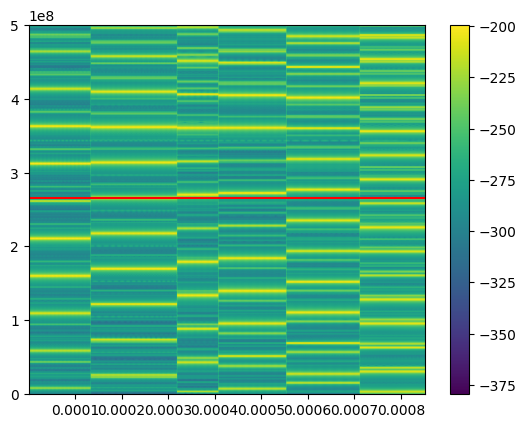

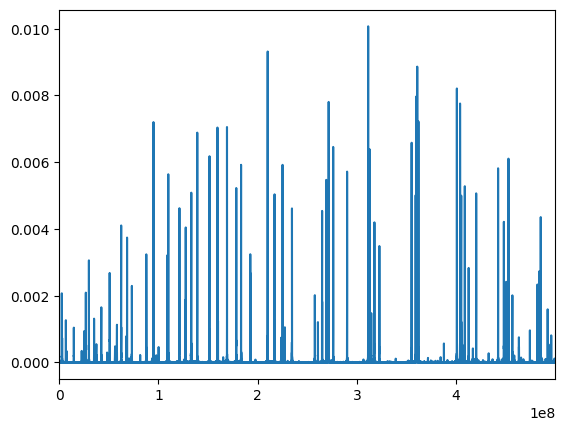

In [6]:
file_names = np.array(file_names)
test_file = file_names[0][0]

print(test_file)

strings, attributes, attributes_values = get_attributes(test_file, full_path=True)
signal = get_signal(test_file, strings[0])

print(attributes)
print(attributes_values)

IMG = plt.specgram(signal, NFFT=1024, Fs=1e9, noverlap=900)[:3]
plt.axhline(y=265013426.66555703, color='r', linestyle='-')
plt.colorbar()

plt.show()
fft = np.fft.fft(signal)

freqs = np.fft.fftfreq(len(fft), d=1e-9)

plt.plot(freqs, np.abs(fft))
plt.xlim(0, np.max(freqs))
plt.show()

carrier_freq_true = attributes_values[0][7]

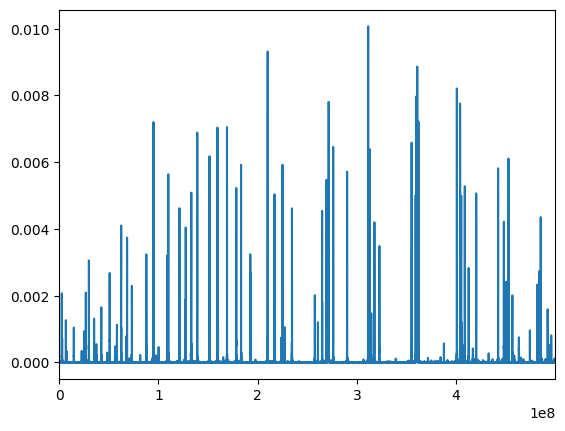

426576
426576


In [7]:
abs_fft = abs(fft)
pos_fft = abs_fft[freqs > 0]
pos_freqs = freqs[freqs > 0]

plt.plot(pos_freqs, pos_fft)
plt.xlim(0, np.max(pos_freqs))
plt.show()

print(len(pos_freqs))
print(len(pos_fft))

In [8]:
def get_half_area(spectrum, freq_axis):
    # Find the half area point
    half_area = np.sum(spectrum) / 2.0
    cumsum = np.cumsum(spectrum)
    
    # Find the index where the cumulative sum is larger than half the total
    half_idx = np.argmax(cumsum > half_area)
    
    # Return the frequency at the half area point
    return freq_axis[half_idx]

half_area_carrier = (get_half_area(pos_fft, pos_freqs))
print(half_area_carrier)

264922001.09476256


In [9]:
import numpy as np
import numba
from numba import jit, prange

@jit(nopython=True, parallel=True)
def find_carrier_frequency_numba(spectrum, freq_axis):
    n = len(spectrum)
    max_symmetry_score = -1.0e10
    carrier_idx = n // 2  # Default to middle if nothing better is found
    
    # Only check middle portion of spectrum
    start_idx = max(n // 4, 10)
    end_idx = min(3 * n // 4, n - 10)
    
    # Use a regular loop for the coarse pass with skipping
    skip = 5
    for i in range(start_idx, end_idx, skip):
        max_offset = min(i, n-i-1)#, n//4)
        
        if max_offset < 10:
            continue
            
        symmetry_score = 0.0
        left_norm = 0.0
        right_norm = 0.0
        
        # Manual calculation
        for j in range(max_offset):
            left_val = spectrum[i-j-1]
            right_val = spectrum[i+j]
            
            symmetry_score += left_val * right_val
            left_norm += left_val * left_val
            right_norm += right_val * right_val
        
        if left_norm > 1.0e-10 and right_norm > 1.0e-10:
            symmetry_score = symmetry_score / np.sqrt(left_norm * right_norm)
            
            if symmetry_score > max_symmetry_score:
                max_symmetry_score = symmetry_score
                carrier_idx = i
    
    # Second pass with prange for fine tuning (step size = 1)
    window_size = 20
    window_start = max(start_idx, carrier_idx - window_size//2)
    window_end = min(end_idx, carrier_idx + window_size//2)
    
    # Use prange with step=1
    for i in prange(window_start, window_end):
        max_offset = min(i, n-i-1, n//4)
        
        if max_offset < 10:
            continue
    
        symmetry_score = 0.0
        left_norm = 0.0
        right_norm = 0.0
        
        for j in range(max_offset):
            left_val = spectrum[i-j-1]
            right_val = spectrum[i+j]
            
            symmetry_score += left_val * right_val
            left_norm += left_val * left_val
            right_norm += right_val * right_val
        
        if left_norm > 1.0e-10 and right_norm > 1.0e-10:
            symmetry_score = symmetry_score / np.sqrt(left_norm * right_norm)
            
            if symmetry_score > max_symmetry_score:
                max_symmetry_score = symmetry_score
                carrier_idx = i
    
    return freq_axis[carrier_idx]

carrier_freq = find_carrier_frequency_numba(pos_fft, pos_freqs)
print(carrier_freq)

360908301.32461584


/Users/nathan/miniforge3/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/nathan/miniforge3/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


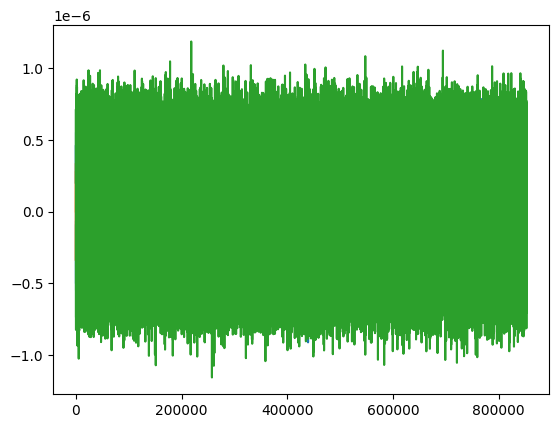

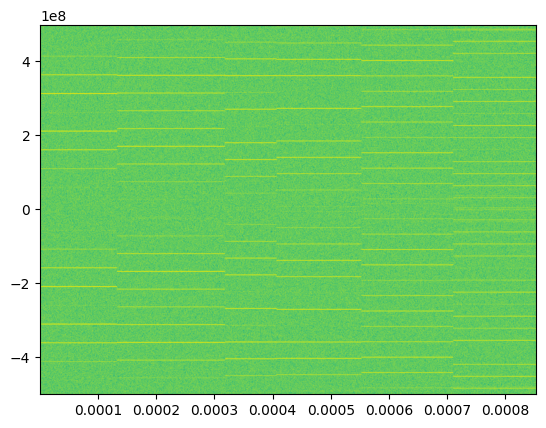

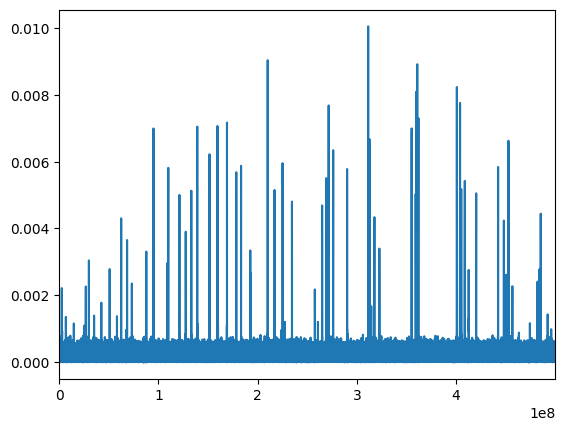

250766275.21675476
132063064.88988492


In [10]:
R, Nch, kb, bw, Nsamp, T= 496.1709043911709, 1, 1.38e-23, 1000e6, len(signal), 0.01

N = 1

npower = kb * T * bw
tau_1t = npower * R


rng = np.random.default_rng()


noise_time = rng.multivariate_normal([0,0],np.eye(2)*tau_1t/2, N*Nsamp) # Generate a 2d gaussian
noise_time = noise_time[:,0] + 1j * noise_time[:,1] # Sample from said Gaussian to get a complex number
noise_time = noise_time.reshape(N, Nsamp) # Reshape the gaussian to be 3d

plt.plot(noise_time[0])
plt.plot(signal)

noisy_signal = signal + noise_time[0]

plt.plot(noisy_signal)
plt.show()

IMG = plt.specgram(noisy_signal, NFFT=1024, Fs=1e9, noverlap=900)[:3]

plt.show()

new_fft = np.fft.fft(noisy_signal)
new_freqs = np.fft.fftfreq(len(new_fft), d=1e-9)

abs_fft = abs(new_fft)
pos_fft = abs_fft[new_freqs > 0]
pos_freqs = new_freqs[new_freqs > 0]

plt.plot(pos_freqs, pos_fft)
plt.xlim(0, np.max(pos_freqs))
plt.show()

carrier_freq = get_half_area(pos_fft, pos_freqs)
print(carrier_freq)

symmetry_freq = find_carrier_frequency_numba(pos_fft, pos_freqs)
print(symmetry_freq)




[10024027.74483123 14249039.60193649 18393941.70166793 20839165.84311691
 25419111.02417389 39399777.5989534  86236159.95706573] [0.03843712 0.05376685 0.06833826 0.07672588 0.09203641 0.13578355
 0.2558918 ]


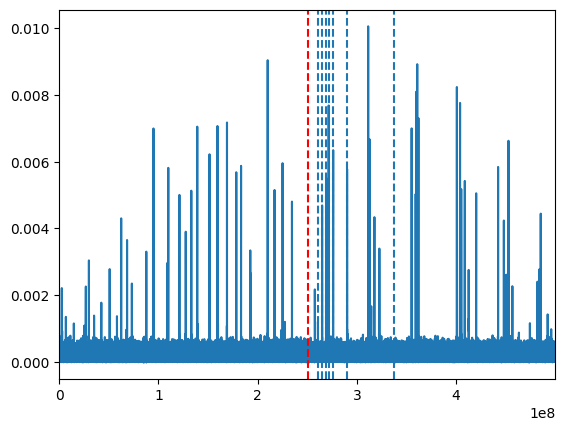

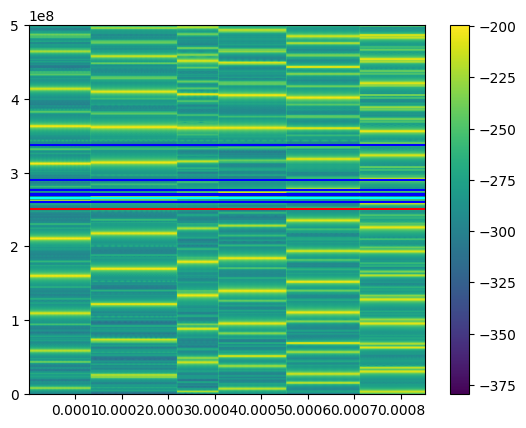

In [11]:
abs_err = np.abs(carrier_freq - carrier_freq_true)
rel_err = abs_err / carrier_freq_true

print(abs_err, rel_err)

plt.plot(pos_freqs, pos_fft)
for i in range(len(carrier_freq_true)):
    plt.axvline(x=carrier_freq_true[i], linestyle='--')
    
plt.axvline(x=carrier_freq, color='r', linestyle='--')

plt.xlim(0, np.max(pos_freqs))
plt.show()

plt.specgram(signal, NFFT=1024, Fs=1e9, noverlap=900)

for i in range(len(carrier_freq_true)):
    plt.axhline(y=carrier_freq_true[i], color='b', linestyle='-')

plt.axhline(y=carrier_freq, color='r', linestyle='-')
plt.axhline(y=half_area_carrier, color='cyan', linestyle='-')
plt.colorbar()
plt.show()


['B_bkg [Tesla]', 'Cyclotron frequency [Hertz]', 'Downmixed cyclotron frequency [Hertz]', 'Energy [eV]', 'LO frequency [Hertz]', 'Pitch angle [degrees]', 'Starting position [metres]', 'Starting velocity [metres/second]', 'Time step [seconds]', 'Waveguide impedance [Ohms]', 'i_coil [Amps]', 'r_coil [metres]', 'r_wg [metres]']
[[1.0048571427712552, 27069009061.79446, 177171460.98929214, 18575.0, 26891837600.80517, 86.7, array([0.00255, 0.     , 0.     ]), array([67847167.01595263, 39629505.13161704,  4530497.80022054]), 1e-09, 495.22952230106034, 154.60765618550025, 0.02, 0.005], [1.0048571427712552, 27069009061.79446, 0.0, 18575.0, 26891837600.80517, 86.7, array([0.00255, 0.     , 0.     ]), array([67847167.01595263, 39629505.13161704,  4530497.80022054]), 1e-09, 495.22952230106034, 154.60765618550025, 0.02, 0.005]]


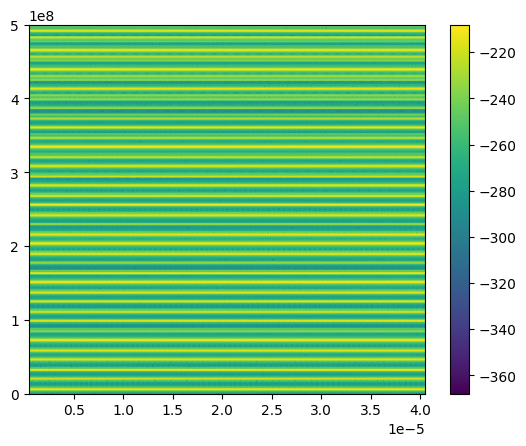

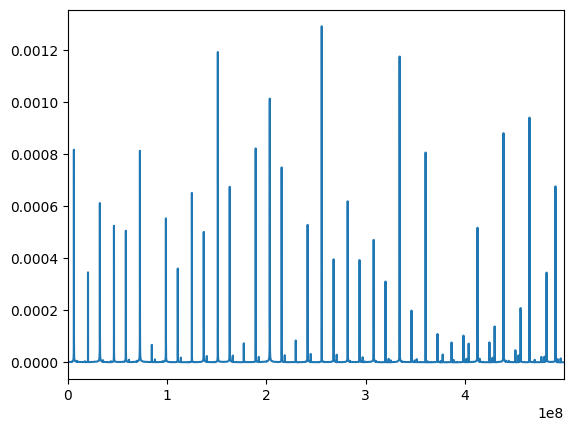

177171460.98929214
207934570.3125
170166015.625


In [12]:
no_scatter = '../../../../Desktop/BatchCreatedFiles/Harmonic/86.7deg_x0.00255/out_9529bcd7-bdc0-49cb-872f-aa8c4974b059.h5'



strings, attributes, attributes_values = get_attributes(no_scatter, full_path=True)
signal = get_signal(no_scatter, strings[0])

print(attributes)
print(attributes_values)

IMG = plt.specgram(signal, NFFT=1024, Fs=1e9, noverlap=900)[:3]
plt.colorbar()

plt.show()
fft = np.fft.fft(signal)

freqs = np.fft.fftfreq(len(fft), d=1e-9)

fft = abs(fft[freqs > 0])
freqs = freqs[freqs > 0]


plt.plot(freqs, fft)
plt.xlim(0, np.max(freqs))
plt.show()

carrier_freq_true = attributes_values[0][2]
print(carrier_freq_true)

half_area_carrier = (get_half_area(fft, freqs))
print(half_area_carrier)

carrier_freq = find_carrier_frequency_numba(fft, freqs)
print(carrier_freq)

In [13]:
def weighted_center_of_mass(spectrum, freq_axis):
    power = spectrum**2  # Assuming the input is magnitude, square to get power
    return np.sum(freq_axis * power) / np.sum(power)  

weighted = weighted_center_of_mass(pos_fft, pos_freqs)
print(weighted)

255888222.92245612


In [14]:
# list of all file names in directory and subdirectories
directory = '../../../../Desktop/BatchCreatedFiles/'

file_list = []
for root, dirs, files in os.walk(directory):
    for file in files:
        if file.endswith(".h5"):
            file_list.append(os.path.join(root, file))

print(len(file_list))

# iterate through and collect the carrier frequencies
carrier_freqs = []
half_area_carriers = []
symmetry_carriers = []
weighted_center_carrier = []

# iterate through and generate the FFT and calculate area based carrier and symmetry based carrier
for i, file in enumerate(file_list):
    strings, attributes, attributes_values = get_attributes(file, full_path=True)
    signal = get_signal(file, strings[0])
    
    fft = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(fft), d=1e-9)
    
    fft = abs(fft[freqs > 0])
    freqs = freqs[freqs > 0]
    
    carrier_freqs.append(attributes_values[0][2])
    
    half_area_carrier = (get_half_area(fft, freqs))
    half_area_carriers.append(half_area_carrier)
    
    carrier_freq = find_carrier_frequency_numba(fft, freqs)
    symmetry_carriers.append(carrier_freq)
    
    weighted = weighted_center_of_mass(fft, freqs)
    weighted_center_carrier.append(weighted)
    
    if i % 100 == 0:
        print('Files processed:', i)
    
    


7349
Files processed: 0
Files processed: 100
Files processed: 200
Files processed: 300
Files processed: 400
Files processed: 500
Files processed: 600
Files processed: 700
Files processed: 800
Files processed: 900
Files processed: 1000
Files processed: 1100
Files processed: 1200
Files processed: 1300
Files processed: 1400
Files processed: 1500
Files processed: 1600
Files processed: 1700
Files processed: 1800
Files processed: 1900
Files processed: 2000
Files processed: 2100
Files processed: 2200
Files processed: 2300
Files processed: 2400
Files processed: 2500
Files processed: 2600
Files processed: 2700
Files processed: 2800
Files processed: 2900
Files processed: 3000
Files processed: 3100
Files processed: 3200
Files processed: 3300
Files processed: 3400
Files processed: 3500
Files processed: 3600
Files processed: 3700
Files processed: 3800
Files processed: 3900
Files processed: 4000
Files processed: 4100
Files processed: 4200
Files processed: 4300
Files processed: 4400
Files processed: 

Half Area Error: 28519793.53074687 0.16663612937890915
Symmetry Error: 72139702.71504441 0.4520652068028518
Weighted Error: 22368440.21824618 0.1336634627604698
Half Area Error: 27277474.036798794 0.17790322665796454
Symmetry Error: 63575999.861608736 0.4819731242702346
Weighted Error: 23866505.310572714 0.15453580463348868


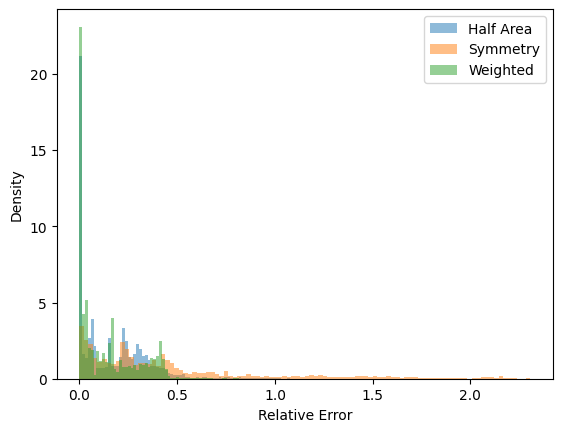

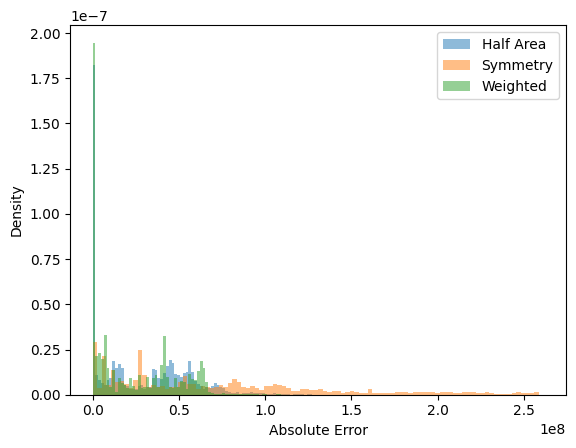

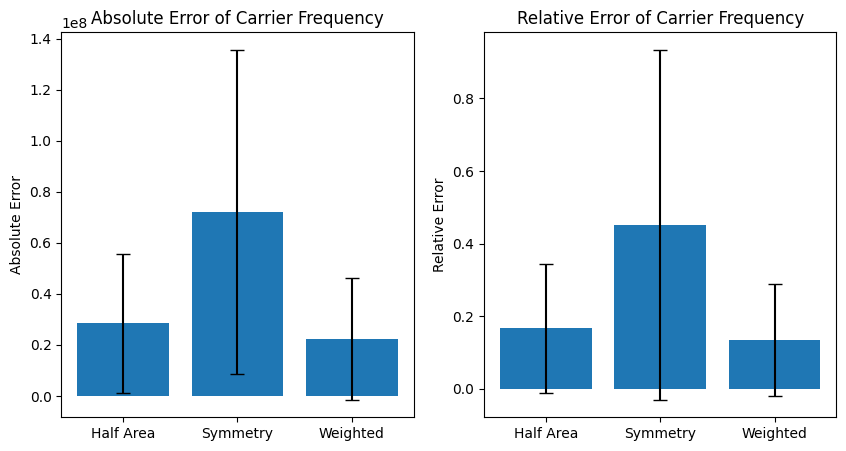

In [15]:
# I want to see which method is better at finding the carrier frequency
half_area_carriers = np.array(half_area_carriers)
symmetry_carriers = np.array(symmetry_carriers)
weighted_center_carriers = np.array(weighted_center_carrier)

carrier_freqs = np.array(carrier_freqs)


half_area_abs_err = np.abs(half_area_carriers - carrier_freqs)
half_area_rel_err = half_area_abs_err / carrier_freqs

symmetry_abs_err = np.abs(symmetry_carriers - carrier_freqs)
symmetry_rel_err = symmetry_abs_err / carrier_freqs

weighted_abs_err = np.abs(weighted_center_carriers - carrier_freqs)
weighted_rel_err = weighted_abs_err / carrier_freqs

print('Half Area Error:', np.mean(half_area_abs_err), np.mean(half_area_rel_err))
print('Symmetry Error:', np.mean(symmetry_abs_err), np.mean(symmetry_rel_err))
print('Weighted Error:', np.mean(weighted_abs_err), np.mean(weighted_rel_err))

print('Half Area Error:', np.std(half_area_abs_err), np.std(half_area_rel_err))
print('Symmetry Error:', np.std(symmetry_abs_err), np.std(symmetry_rel_err))
print('Weighted Error:', np.std(weighted_abs_err), np.std(weighted_rel_err))

# plot the errors for the two methods of finding the carrier frequency
plt.hist(half_area_rel_err, bins=100, alpha=0.5, label='Half Area', density=True)
plt.hist(symmetry_rel_err, bins=100, alpha=0.5, label='Symmetry', density=True)
plt.hist(weighted_rel_err, bins=100, alpha=0.5, label='Weighted', density=True)

plt.xlabel('Relative Error')
plt.ylabel('Density')
plt.legend()
plt.show()

# plot the errors for the two methods of finding the carrier frequency
plt.hist(half_area_abs_err, bins=100, alpha=0.5, label='Half Area', density=True)
plt.hist(symmetry_abs_err, bins=100, alpha=0.5, label='Symmetry', density=True)
plt.hist(weighted_abs_err, bins=100, alpha=0.5, label='Weighted', density=True)

plt.xlabel('Absolute Error')
plt.ylabel('Density')
plt.legend()
plt.show()

# create bar chart with absolute errors and relative errors
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].bar(['Half Area', 'Symmetry', 'Weighted'], [np.mean(half_area_abs_err), np.mean(symmetry_abs_err), np.mean(weighted_abs_err)], yerr=[np.std(half_area_abs_err), np.std(symmetry_abs_err), np.std(weighted_abs_err)], capsize=5)
ax[0].set_ylabel('Absolute Error')
ax[0].set_title('Absolute Error of Carrier Frequency')

ax[1].bar(['Half Area', 'Symmetry', 'Weighted'], [np.mean(half_area_rel_err), np.mean(symmetry_rel_err), np.mean(weighted_rel_err)], yerr=[np.std(half_area_rel_err), np.std(symmetry_rel_err), np.std(weighted_rel_err)], capsize=5)
ax[1].set_ylabel('Relative Error')
ax[1].set_title('Relative Error of Carrier Frequency')

plt.show()



What does this actually look like?

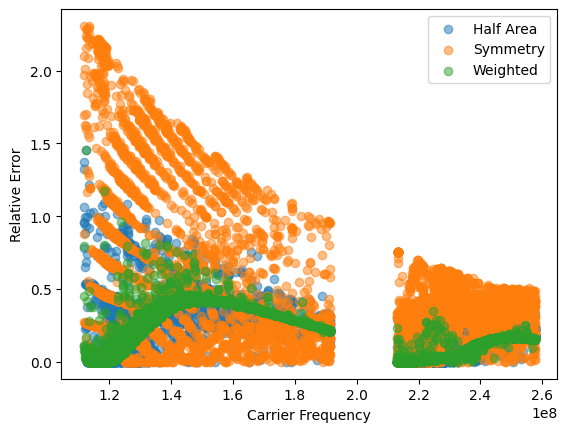

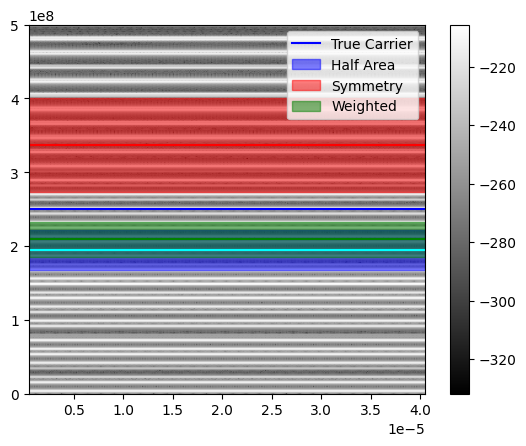

In [22]:
# plot the errors for the two methods of finding the carrier frequency
plt.scatter(carrier_freqs, half_area_rel_err, alpha=0.5, label='Half Area')
plt.scatter(carrier_freqs, symmetry_rel_err, alpha=0.5, label='Symmetry')
plt.scatter(carrier_freqs, weighted_rel_err, alpha=0.5, label='Weighted')

plt.xlabel('Carrier Frequency')
plt.ylabel('Relative Error')
plt.legend()
plt.show()

plt.specgram(signal, NFFT=1024, Fs=1e9, noverlap=900, cmap='gray')
plt.axhline(y=carrier_freqs[-1], color='b', linestyle='-', label='True Carrier')
# fill region between st deviation lines
plt.fill_betweenx([half_area_carriers[-1] - np.std(half_area_abs_err), half_area_carriers[-1] + np.std(half_area_abs_err)], 0.05e-5, 4.05e-5, color='b', alpha=0.5, label='Half Area')
plt.axhline(y=half_area_carriers[-1], color='cyan', linestyle='-')
plt.fill_betweenx([symmetry_carriers[-1] - np.std(symmetry_abs_err), symmetry_carriers[-1] + np.std(symmetry_abs_err)], 0.05e-5, 4.05e-5, color='r', alpha=0.5, label='Symmetry')
plt.axhline(y=symmetry_carriers[-1], color='r', linestyle='-')
plt.fill_betweenx([weighted_center_carrier[-1] - np.std(weighted_abs_err), weighted_center_carrier[-1] + np.std(weighted_abs_err)], 0.05e-5, 4.05e-5, color='g', alpha=0.5, label='Weighted')
plt.axhline(y=weighted_center_carrier[-1], color='g', linestyle='-')
plt.colorbar()
plt.legend()



plt.show()

Running this investigation again but on a pitch angle and radii magnitude basis would be good. 


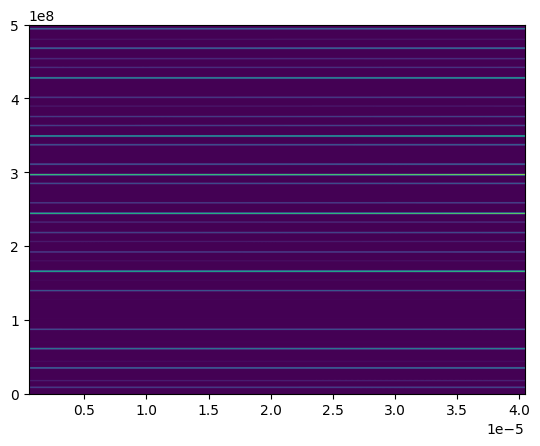

In [17]:
slice = 100

plt.imshow(IMG[0], aspect='auto', extent=[np.min(IMG[2]), np.max(IMG[2]),
                                          np.min(IMG[1]), np.max(IMG[1])]);

In [18]:
keras.Model()

Making a model

In [19]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import numpy as np

from tensorflow.keras import datasets, layers, models

In [20]:
t_data = np.array(training_data)
np.shape(t_data[5][0])

NameError: name 'training_data' is not defined

In [ ]:

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(129, 22, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='relu'))

Problems to solve:

- What is our output?
    - Array of specific scatter time indices? (e.g. if there is a single scatter -> output = [X], where X is time index of scatter location)
        - How do we monitor accuracy, distance from true scatter? Have a feeling we will be plagued with ghost scatters.
    - Output along time axis list of probabilities of scatter.
        - but how do we get the probability? do we do this using a prior and use bayesian inference, matching against standard interaction time? No feels off. 
        - how about validating the energy of slices 


- We need a smart, robust, adaptive method of detecting scatters. 


- Alternative approaches 
    - GNN node finding. Find ends of tracks and hence scatters on specgram images.
    - Tuning the images? 
    - Rotation invariance, is there any point in regularising like for other computer vision applications?


Do we need to take a step back and take specific slices of spectrograms? Or do we need to pad grams to bolster our adaptability. 


How will the detection perform under gaussian noise, other noise? artefacts? and for different normalisations. Need to ponder whether normalising to the maximum power in the gram makes sense or if the magnitude is as important as the relative magnitude. 